# Classification Tasks for the Harper-valley dataset

In this section, we build classifiers for the harper-valley dataset. In particular, we build:
- a multi-class classifier for categorising each conversation in the dataset according to its intent, using a Logistic regression model and a pre-trained Transformer model;
- a multi-label classifier for categorising each utterance of every conversation in the dataset according to its dialogue-action, using a pre-trained Transformer model.
- a multi-class classifier for categorising each utterance of every conversation in the dataset according to its emotional valence, using a pre-trained Transformer model.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

path = 'NLP-Project'

os.chdir(f'/content/drive/MyDrive/{path}')
os.getcwd()

'/content/drive/MyDrive/NLP-Project'

## Prepare the environment


In [ ]:
!pip3 install torch
!pip3 install -q transformers datasets
!pip3 install --upgrade scikit-learn==1.0.2
!pip3 install matplotlib
!pip3 install accelerate -U
!pip3 install evaluate

In [ ]:
import torch
import numpy as np
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
import evaluate

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    raise SystemError('GPU device not found')

Get the data

In [ ]:
metadata = pd.read_csv('Metadata.csv')
transcript_data = pd.read_csv('TranscriptDB.csv')

Clean the data by removing noise and unknown symbols from the human transcription

In [ ]:
transcript_data_sorted = transcript_data.sort_values(by=['index'])

# The unique words included in the conversations which don't have a specific meaning, for example [noise] [cough] ecc
unique_words = set(word for sublist in transcript_data_sorted['human_transcript'].str.findall(r'\[([^\]]+)\]').dropna() for word in sublist)

print(unique_words)

pattern = r'(\[(' + '|'.join(unique_words) + r')\])|\<unk\>'

# Substitute the unique words and the <unk> symbols in each conversation with the empty '' string
transcript_data_sorted['human_transcript'] = transcript_data_sorted['human_transcript'].replace(to_replace=pattern, value='', regex=True).str.strip()

# Remove frome the dataframe the rows for wich the human_transcript is empty
transcript_data_sorted.drop(transcript_data_sorted[transcript_data_sorted['human_transcript'] == ''].index, inplace=True)
transcript_data_sorted = transcript_data_sorted.dropna(subset=['human_transcript'])


{'dogs', 'kids', 'music', 'laughter', 'unintelligible', 'ringing', 'noise', 'baby', 'cough'}


## Classification of each conversation according to its intent



Obtain the conversations by merging the transcript and the metadata dataframes

In [ ]:
transcript_data_grouped_by_id = transcript_data_sorted.groupby('identifier')['human_transcript'].apply(list)
data = metadata.merge(transcript_data_grouped_by_id, on='identifier', how='left')
data.head(10)

Get the conversations and the intents

In [ ]:
conversations = data['human_transcript'].tolist()
intents = data["intent"].tolist()

categories = list(set(intents))

In [ ]:
for i in range(10) :
  print(conversations[i])
  print(intents[i])
  print("\n\n")

['hello this is harper valley national bank my name is john how can i help you today'
 nan
 'hi my name is elizabeth miller i would like to transfer money between my accounts'
 '[noise] what is the transfer amount'
 'um it is a hundred and seventeen dollars'
 'one hundred and seventeen dollars' 'yes'
 'and what is the source account' 'um from my checking to my savings'
 'can you please repeat the destination account' nan 'um savings account'
 'one hundred and seventeen dollars has been transferred from your checking account to your savings account is there anything else i can help you with'
 nan "nope that'll be all thank you" nan
 'thank you for calling have a great day' 'you too']
transfer money


Let's compute the occurrences of the classes

In [ ]:
counts = Counter(intents)
counts

Counter({'schedule appointment': 178,
         'transfer money': 170,
         'get branch hours': 190,
         'replace card': 187,
         'check balance': 203,
         'pay bill': 180,
         'order checks': 179,
         'reset password': 159})

The plot below shows that there is a relatively even distribution of conversations across the categories:

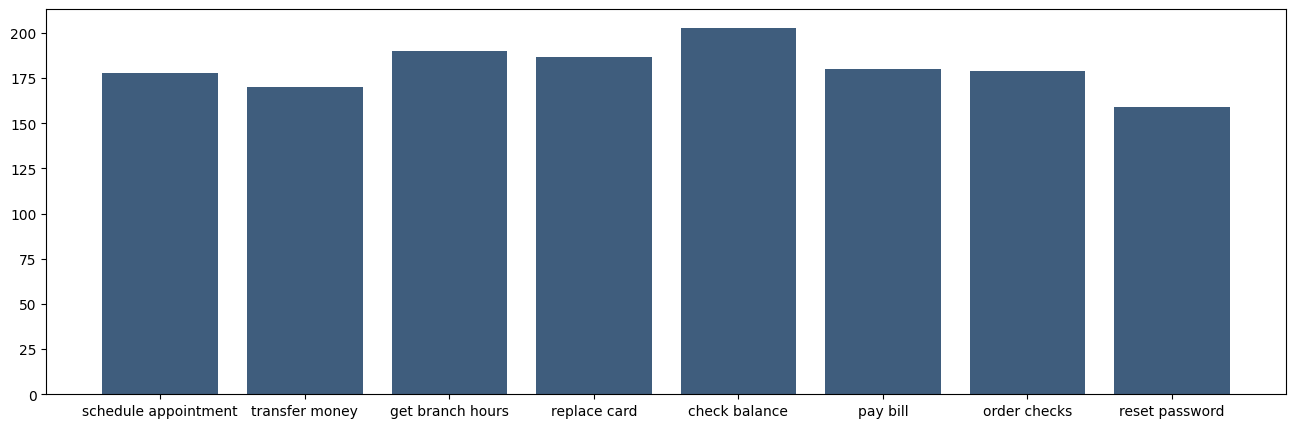

In [ ]:
plt.figure(figsize=(16,5))
plt.bar(counts.keys(), counts.values(), color="#3F5D7D");

Split the data in training, validation and testing

In [ ]:
temp_x, test_x, temp_y, test_y = train_test_split(conversations, intents, test_size=0.2)
train_x, valid_x, train_y, valid_y = train_test_split(temp_x, temp_y, test_size=0.2)

### 1) Linear model training and evaluation

#### Importing the embedding model and preprocessing data

We embed the conversations using the wiki embedding model

In [ ]:
!pip install --upgrade gensim

In [ ]:
import gensim.downloader as api
import re
import string

regex = '[' + string.punctuation + ']'
model_wiki = api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
def vectorize(docs, embedding_model=model_wiki, useSum=True):
    vectors = np.zeros((len(docs),50))
    for i in range(len(docs)):
        doc = re.sub('noise', '', docs[i])
        doc = re.sub('unk', '', doc)
        tokens = re.sub(regex, '', doc.lower()).split()
        embeddings = [embedding_model.get_vector(token) for token in tokens if token in embedding_model]
        if (len(embeddings) > 0):
            if (useSum):
                vectors[i] = sum(embeddings)
            else:
                vectors[i] = np.mean(embeddings, axis=0)
    return vectors

In [ ]:
train_x_vector = vectorize(train_x)
val_x_vector = vectorize(valid_x)
test_x_vector = vectorize(test_x)

#### Creating and Training the model

We define a Logistic Regression model and we fit the vectorized training data

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression().fit(train_x_vector, train_y)

#### Evaluating the model on the test set

In [ ]:
y_pred = lr_model.predict(test_x_vector)

print(classification_report(test_y, y_pred, target_names=categories))

                      precision    recall  f1-score   support

schedule appointment       1.00      0.98      0.99        46
        order checks       1.00      1.00      1.00        31
    get branch hours       1.00      0.97      0.99        36
       check balance       1.00      1.00      1.00        40
        replace card       1.00      1.00      1.00        30
            pay bill       1.00      1.00      1.00        35
      reset password       0.97      1.00      0.99        35
      transfer money       0.97      1.00      0.99        37

            accuracy                           0.99       290
           macro avg       0.99      0.99      0.99       290
        weighted avg       0.99      0.99      0.99       290



The Logistic regression model has already almost optimal performance

### 2) Pre-trained Transformer model training and evaluation

#### Creating a model and preprocessing data

We use the distilbert model

In [ ]:
model_name = 'distilbert-base-uncased'

In [ ]:
bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(categories))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Move model to GPU

In [ ]:
bert = bert.to(device)

Load the tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Preprocess the training, validation and test data using the transformer's data set API

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(categories)

In [ ]:
train_data = [{'text': txt, 'label': label_encoder.transform([lbl])[0]} for txt, lbl in zip(train_x, train_y)]
val_data = [{'text': txt, 'label': label_encoder.transform([lbl])[0]} for txt, lbl in zip(valid_x, valid_y)]
test_data = [{'text': txt, 'label': label_encoder.transform([lbl])[0]} for txt, lbl in zip(test_x, test_y)]

Convert the data sets into the Huggingface data set API format

In [ ]:
train_data = Dataset.from_list(train_data)
val_data = Dataset.from_list(val_data)
test_data = Dataset.from_list(test_data)

Create a container with all the splits of the data set


In [ ]:
data = DatasetDict()
data['train'] = train_data
data['validation'] = val_data
data['test'] = test_data

Use the tokenizer to convert the input strings into sequences of tokens

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

tokenized_data = data.map(tokenize_function, batched=True)

Map:   0%|          | 0/924 [00:00<?, ? examples/s]

Map:   0%|          | 0/232 [00:00<?, ? examples/s]

Map:   0%|          | 0/290 [00:00<?, ? examples/s]

#### Training the model



Prepare training arguments

In [ ]:
training_args = TrainingArguments(
    output_dir='./conversation_intent_classification',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    evaluation_strategy="epoch",
)

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

Build the trainer using the Huggingface trainer API

In [ ]:
trainer = Trainer(
    model=bert,
    args=training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['validation'],
    compute_metrics=compute_metrics
)

Run the training process



In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.043344,0.995690,0.995667,0.995797,0.995690
2,No log,0.035993,0.995690,0.995667,0.995797,0.995690
3,No log,0.035839,0.995690,0.995667,0.995797,0.995690


TrainOutput(global_step=348, training_loss=0.22874965886960083, metrics={'train_runtime': 107.1979, 'train_samples_per_second': 25.859, 'train_steps_per_second': 3.246, 'total_flos': 277580980531008.0, 'train_loss': 0.22874965886960083, 'epoch': 3.0})

#### Evaluating the model



First we run the evaluation process included with the trainer

In [ ]:
trainer.evaluate()

{'eval_loss': 0.03583887964487076,
 'eval_accuracy': 0.9956896551724138,
 'eval_f1': 0.9956668155471866,
 'eval_precision': 0.9957974137931035,
 'eval_recall': 0.9956896551724138,
 'eval_runtime': 2.2298,
 'eval_samples_per_second': 104.045,
 'eval_steps_per_second': 13.006,
 'epoch': 3.0}

Then we get the predictions on the test set

In [ ]:
preds = trainer.predict(tokenized_data['test'])


Convert predicted logits to classes using the $\mathrm{argmax}$ operator

In [ ]:
y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()

Print the classification report

In [ ]:
print(classification_report(label_encoder.transform(test_y), y_pred, target_names=categories))

                      precision    recall  f1-score   support

       check balance       1.00      1.00      1.00        46
    get branch hours       1.00      1.00      1.00        31
        order checks       1.00      1.00      1.00        36
            pay bill       1.00      1.00      1.00        40
        replace card       1.00      1.00      1.00        30
      reset password       1.00      1.00      1.00        35
schedule appointment       1.00      1.00      1.00        35
      transfer money       1.00      1.00      1.00        37

            accuracy                           1.00       290
           macro avg       1.00      1.00      1.00       290
        weighted avg       1.00      1.00      1.00       290



We  have a look at the test examples on which the model made the worst predictions:

Compute loss

In [ ]:
loss = torch.nn.functional.cross_entropy(torch.tensor(preds.predictions), torch.tensor(preds.label_ids), reduction='none')

Identify the index of the element with the highest loss

In [ ]:
index_of_instance = torch.argmax(loss).item()
index_of_instance

41

Loss of the corresponding sample

In [ ]:
loss[index_of_instance].item()

0.4319033622741699

Predicted class and target class

In [ ]:
print(f'Target class:    {intents[index_of_instance]}')
print(f'Predicted class: {label_encoder.inverse_transform([y_pred[index_of_instance]])[0]}')

Target class:    check balance
Predicted class: check balance


Print out the conversation with the top loss

In [ ]:
print(conversations[index_of_instance])

['hello this is harper valley national bank'
 'my name is james how can i help you today'
 '[noise] hi my name is elizabeth wilson i need to check my account balance'
 'which account would you like to check' 'my savings account'
 'your savings account balance is eighty seven dollars'
 'is there anything else i can help you with' 'okay'
 "no that'll be all thank you" 'thank you for calling have a great day'
 nan nan]


#### Saving and Loading the model

We save the predictor for later use

In [ ]:
bert.save_pretrained('./conversation_intent_classification')

In [ ]:
bert = AutoModelForSequenceClassification.from_pretrained('./conversation_intent_classification').to(device)

In [ ]:
@torch.no_grad()
def predict(text):
    input_encodings = tokenizer(text, return_tensors='pt').to(device)
    outputs = bert(**input_encodings)

    lbl = label_names[torch.argmax(outputs.logits).item()]

    return lbl

In [ ]:
sample_text = conversations[100]
predict(sample_text)

'get branch hours'

## Classification of each utterance according to its dialogue actions

Get the utterances and their corresponding dialog_acts labels

In [ ]:
utterances = transcript_data_sorted['human_transcript'].tolist()
dialog_acts = transcript_data_sorted['dialog_acts'].tolist()

# All the classes are enclosed in single quotes
pattern = r"'([^']+)'"


for i in range(len(dialog_acts)):
  dialog_acts[i] = re.findall(pattern, dialog_acts[i])

In [ ]:
for i in range(6000,6010) :
  print(utterances[i])
  print(dialog_acts[i])
  print("\n\n")

the company is fossil gas
['gridspace_response']



hi my name is elizabeth jones i would like to pay a bill
['gridspace_greeting', 'gridspace_problem_description']



yes my home address is seven two five
['gridspace_response', 'gridspace_data_response']



my address is
['gridspace_greeting', 'gridspace_data_response']



hi my name is john johnson i need to check my account balance
['gridspace_greeting', 'gridspace_problem_description']



which card would you like to replace
['gridspace_data_question', 'gridspace_other']



okay one second
['gridspace_other', 'gridspace_bear_with_me']



from my checking account to my savings account
['gridspace_response', 'gridspace_problem_description']



how can i help you today
['gridspace_greeting', 'gridspace_open_question']



is there anything else i can help you with
['gridspace_other', 'gridspace_open_question']





Let's compute the occurrences of the classes

In [ ]:
flattened_dialog_acts = [
    d
    for ds in dialog_acts
    for d in ds
]

counts = Counter(flattened_dialog_acts)

classes = list(set(flattened_dialog_acts))

In [ ]:
classes

['gridspace_data_question',
 'gridspace_closing',
 'gridspace_confirm_data',
 'gridspace_response',
 'gridspace_greeting',
 'gridspace_filler_disfluency',
 'gridspace_open_question',
 'gridspace_problem_description',
 'gridspace_bear_with_me',
 'gridspace_yes_response',
 'gridspace_acknowledgement',
 'gridspace_other',
 'gridspace_thanks',
 'gridspace_data_response',
 'gridspace_data_communication',
 'gridspace_procedure_explanation']

The plot below shows that there is an unbalanced distribution of the dialog actions

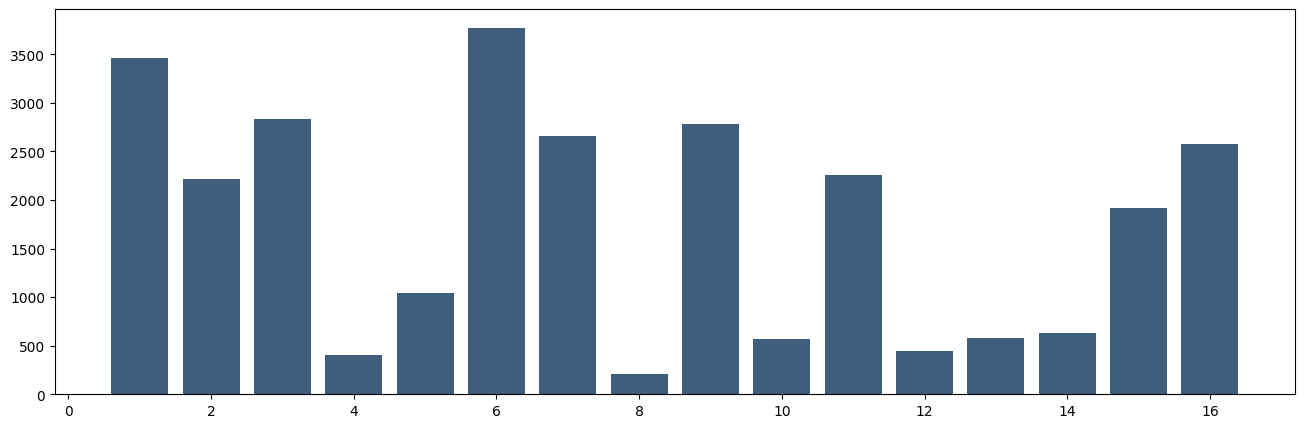

In [ ]:
plt.figure(figsize=(16,5))
plt.bar(range(1,len(counts.keys())+1), counts.values(), color="#3F5D7D");

Split the data in training, validation and testing

In [ ]:
temp_x, test_x, temp_y, test_y = train_test_split(utterances, dialog_acts, test_size=0.2)
train_x, valid_x, train_y, valid_y = train_test_split(temp_x, temp_y, test_size=0.2)

### Creating a model and preprocessing data

We use the distilbert model

In [ ]:
class2id = {class_:id for id, class_ in enumerate(classes)}
id2class = {id:class_ for class_, id in class2id.items()}

In [ ]:
model_name = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(

   model_name, num_labels=len(classes),
           id2label=id2class, label2id=class2id,
                       problem_type = "multi_label_classification")

model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preprocess the training, validation and test data using the transformer's data set API and preprocess the labels so that they are vector of binary values (utterance has label or not for each label)

In [ ]:
def get_labels_vector(all_labels):
    labels = [0. for i in range(len(classes))]
    for label in all_labels:
          label_id = class2id[label]
          labels[label_id] = 1.

    return labels

train_data = [{'text': txt, 'label': get_labels_vector(lbl)} for txt, lbl in zip(train_x, train_y)]
val_data = [{'text': txt, 'label': get_labels_vector(lbl)} for txt, lbl in zip(valid_x, valid_y)]
test_data = [{'text': txt, 'label': get_labels_vector(lbl)} for txt, lbl in zip(test_x, test_y)]

Convert the data sets into the Huggingface data set API format

In [ ]:
train_data = Dataset.from_list(train_data)
val_data = Dataset.from_list(val_data)
test_data = Dataset.from_list(test_data)

Create a container with all the splits of the data set

In [ ]:
data = DatasetDict()
data['train'] = train_data
data['validation'] = val_data
data['test'] = test_data

Use the tokenizer to convert the input strings into sequences of tokens

In [ ]:
def preprocess_function(example):
    return tokenizer(example['text'], truncation=True, padding=True)


tokenized_dataset = data.map(preprocess_function, batched=True)

Map:   0%|          | 0/12352 [00:00<?, ? examples/s]

Map:   0%|          | 0/3088 [00:00<?, ? examples/s]

Map:   0%|          | 0/3861 [00:00<?, ? examples/s]

### Training the model

Define the training arguments

In [ ]:
training_args = TrainingArguments(
   output_dir='./utterances_dialogue_acts_classification',
   learning_rate=2e-5,
   per_device_train_batch_size=3,
   per_device_eval_batch_size=3,
   num_train_epochs=3,
   weight_decay=0.01,
   evaluation_strategy="epoch",
   save_strategy = "epoch"
)


Define the metrics to compute. In this case the metric are computed by flattening the predictions

In [ ]:
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

def sigmoid(x):
   return 1/(1 + np.exp(-x))

def compute_metrics(eval_pred):

   predictions, labels = eval_pred
   predictions = sigmoid(predictions)
   predictions = (predictions > 0.5).astype(int).reshape(-1)
   return clf_metrics.compute(predictions=predictions, references=labels.astype(int).reshape(-1))


Build the trainer using the Huggingface trainer API

In [ ]:
trainer = Trainer(

   model=model,
   args=training_args,
   train_dataset=tokenized_dataset["train"],
   eval_dataset=tokenized_dataset["validation"],
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
)


Run the training process

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.144500,0.132999,0.949947,0.694578,0.787454,0.621299
2,0.135700,0.129497,0.950696,0.683719,0.829030,0.581750
3,0.123500,0.128846,0.951222,0.696474,0.809900,0.610915


TrainOutput(global_step=12354, training_loss=0.1406178486005608, metrics={'train_runtime': 767.8064, 'train_samples_per_second': 48.262, 'train_steps_per_second': 16.09, 'total_flos': 351125473921248.0, 'train_loss': 0.1406178486005608, 'epoch': 3.0})

### Evaluating the model

First we run the evaluation process included in the trainer

In [ ]:
trainer.evaluate()

{'eval_loss': 0.1288457214832306,
 'eval_accuracy': 0.9512224740932642,
 'eval_f1': 0.6964735516372796,
 'eval_precision': 0.809900410076157,
 'eval_recall': 0.6109147149801148,
 'eval_runtime': 9.8271,
 'eval_samples_per_second': 314.234,
 'eval_steps_per_second': 104.813,
 'epoch': 3.0}

Then we get the predictions on the test set

In [ ]:
preds = trainer.predict(tokenized_dataset['test'])


In [ ]:
predictions, labels = preds.predictions, preds.label_ids
predictions = sigmoid(predictions)
predictions = (predictions > 0.5).astype(int)

In [ ]:
labels.shape, predictions.shape, len(test_y)

((3861, 16), (3861, 16), 3861)

Print the two accuracies: ratio of example that matches perfectly (Subset Accuracy) and accurracy after flattening the predictions and the true labels

In [ ]:
true_labels = [get_labels_vector(all_labels) for all_labels in test_y]

In [ ]:
print(f"Subset Accuracy : {accuracy_score(true_labels, predictions)}")
print(f"Flattened prediction Accuracy : {accuracy_score(np.array(true_labels).reshape(-1), predictions.reshape(-1))}")

Subset Accuracy : 0.47241647241647244
Flattened prediction Accuracy : 0.9493168868168869


In [ ]:
print(classification_report(true_labels, predictions, target_names=classes, zero_division = 0.0))

                                 precision    recall  f1-score   support

        gridspace_data_question       0.92      0.77      0.84       557
              gridspace_closing       0.92      0.92      0.92       529
         gridspace_confirm_data       0.40      0.02      0.03       116
             gridspace_response       0.55      0.07      0.13       480
             gridspace_greeting       0.91      0.92      0.91       714
    gridspace_filler_disfluency       0.74      0.33      0.46        69
        gridspace_open_question       0.85      0.81      0.83       427
  gridspace_problem_description       0.71      0.55      0.62       520
         gridspace_bear_with_me       0.93      0.37      0.53        38
         gridspace_yes_response       0.73      0.41      0.53        87
      gridspace_acknowledgement       0.89      0.60      0.72       224
                gridspace_other       0.68      0.43      0.53       746
               gridspace_thanks       0.87      0.

It seems that the model fail to identify some classes

### Saving the model


We save the predictor for later use

In [ ]:
model.save_pretrained('./utterances_dialogue_acts_classification')

## Emotional Valence Classification

Get the utterances and their corresponding emotional valence values

In [ ]:
utterances = transcript_data_sorted['human_transcript'].tolist()
emotion_positive = transcript_data_sorted['emotion_positive'].tolist()
emotion_negative = transcript_data_sorted['emotion_negative'].tolist()
emotion_neutral = transcript_data_sorted['emotion_neutral'].tolist()
emotions_values = [[positive, neutral, negative] for positive, neutral, negative in zip(emotion_positive, emotion_neutral, emotion_negative)]

emotions = ["Positive", "Neutral", "Negative"]

From the details below, we observse that there is a soft assignment of the utterances to each emotional valence

In [ ]:
for i in range(5000,5010) :
  print(utterances[i])
  print(f" Positive : {emotions_values[i][0]}")
  print(f" Neutral : {emotions_values[i][1]}")
  print(f" Negative : {emotions_values[i][2]}")
  print("\n\n")

my checking account
 Positive : 0.1226877868175506
 Neutral : 0.4970431327819824
 Negative : 0.3802690505981445



what is the company address
 Positive : 0.1197834908962249
 Neutral : 0.5146397352218628
 Negative : 0.365576833486557



i would like to pay a bill
 Positive : 0.1808052062988281
 Neutral : 0.5283222198486328
 Negative : 0.2908725440502167



three two seven
 Positive : 0.2218691855669021
 Neutral : 0.5674993991851807
 Negative : 0.2106314599514007



sunday
 Positive : 0.1740027517080307
 Neutral : 0.5154054164886475
 Negative : 0.3105918765068054



yeah sure what day what time
 Positive : 0.2075949758291244
 Neutral : 0.5357312560081482
 Negative : 0.2566737830638885



the amount is one hundred and forty dollars
 Positive : 0.1150112450122833
 Neutral : 0.5300272703170776
 Negative : 0.354961484670639



what are the local branch hours
 Positive : 0.0719977095723152
 Neutral : 0.5420213341712952
 Negative : 0.3859809637069702



i just wanted to ask what the local bra

Split the data in training, validation and testing

In [ ]:
temp_x, test_x, temp_y, test_y = train_test_split(utterances, emotions_values, test_size=0.2)
train_x, valid_x, train_y, valid_y = train_test_split(temp_x, temp_y, test_size=0.2)

### Creating a model and preprocessing data

We use the distilbert model

In [ ]:
model_name = 'distilbert-base-uncased'

tokenizer_e = AutoTokenizer.from_pretrained(model_name)

emotional_valence_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(emotions))

emotional_valence_model = emotional_valence_model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pr

Preprocess the training, validation and test data using the transformer's data set API

In [ ]:
train_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(train_x, train_y)]
val_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(valid_x, valid_y)]
test_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(test_x, test_y)]

Convert the data sets into the Huggingface data set API format

In [ ]:
train_data = Dataset.from_list(train_data)
val_data = Dataset.from_list(val_data)
test_data = Dataset.from_list(test_data)

Create a container with all the splits of the data set

In [ ]:
data = DatasetDict()
data['train'] = train_data
data['validation'] = val_data
data['test'] = test_data

Use the tokenizer to convert the input strings into sequences of tokens

In [ ]:
def preprocess_function_e(example):
    return tokenizer_e(example['text'], truncation=True, padding=True)


tokenized_dataset = data.map(preprocess_function_e, batched=True)

Map:   0%|          | 0/12352 [00:00<?, ? examples/s]

Map:   0%|          | 0/3088 [00:00<?, ? examples/s]

Map:   0%|          | 0/3861 [00:00<?, ? examples/s]

### Training the model

Define the training arguments

In [ ]:
training_args = TrainingArguments(
   output_dir='./utterances_emotional_valence_classification',
   learning_rate=2e-5,
   per_device_train_batch_size=3,
   per_device_eval_batch_size=3,
   num_train_epochs=2,
   weight_decay=0.01,
   evaluation_strategy="epoch",
   save_strategy = "epoch"
)


Build the trainer using the Huggingface trainer API

In [ ]:
trainer = Trainer(

   model=emotional_valence_model,
   args=training_args,
   train_dataset=tokenized_dataset["train"],
   eval_dataset=tokenized_dataset["validation"],
   tokenizer=tokenizer_e
)


Run the training process

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.546200,0.550048
2,0.547000,0.549134


TrainOutput(global_step=8236, training_loss=0.5492902499139164, metrics={'train_runtime': 460.3809, 'train_samples_per_second': 53.66, 'train_steps_per_second': 17.89, 'total_flos': 281772237248118.0, 'train_loss': 0.5492902499139164, 'epoch': 2.0})

### Evaluating the model

Since there is a soft-assigment of the labels, we use the cross-entropy loss as the main metric to evaluate the model

First we run the evaluation process included in the trainer

In [ ]:
trainer.evaluate()

{'eval_loss': 0.5491340756416321,
 'eval_runtime': 8.3341,
 'eval_samples_per_second': 370.528,
 'eval_steps_per_second': 123.589,
 'epoch': 2.0}

Then we get the predictions on the test set

In [ ]:
y_pred = trainer.predict(tokenized_dataset['test'])
y_pred_max = torch.argmax(torch.tensor(y_pred.predictions), dim=1).numpy()

In [ ]:
def softmax(y_pred):
   sum = np.sum([np.exp(y_pred[i]) for i in range(y_pred.shape[0])])
   return [np.exp(y_pred[i])/sum for i in range(y_pred.shape[0])]

def cross_entropy_loss(y_true, y_pred):
    y_pred = [softmax(y_pred[i]) for i in range(y_pred.shape[0])]
    # Ensure the predictions are between 0 and 1
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    # Compute the cross-entropy loss
    loss = -np.sum(y_true * np.log(y_pred), axis=1)
    # Return the mean loss
    return np.average(loss)

In [ ]:
loss = cross_entropy_loss(np.array(test_y), torch.tensor(y_pred.predictions).numpy())
print("Cross-Entropy Loss:", loss)

Cross-Entropy Loss: 0.955624738907415


We can also pick the max of both the true assignment and the prediction and compute the standard metrics (accuracy, f1-score ecc)

In [ ]:
y_test_max = np.argmax(test_y, axis=1)

print(classification_report(y_test_max, y_pred_max, target_names=emotions))

              precision    recall  f1-score   support

    Positive       0.93      0.93      0.93      1588
     Neutral       0.94      0.94      0.94      2188
    Negative       0.75      0.69      0.72        85

    accuracy                           0.93      3861
   macro avg       0.87      0.86      0.87      3861
weighted avg       0.93      0.93      0.93      3861



### Saving the model

We save the predictor for later use

In [ ]:
emotional_valence_model.save_pretrained('./utterances_emotional_valence_classification')